## Setup

In [1]:
import numpy as np
import torch
from torchvision import models
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as T


from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

from train import *
from data_utils import *

%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.cuda.FloatTensor if use_cuda else torch.float32
torch.backends.cudnn.benchmark = True

print('use cuda = ', use_cuda)

use cuda =  True


In [2]:
## Load the data
data = load_bolete_data()

ItemsViewHDF5(<HDF5 file "bolete.h5" (mode r)>)


In [3]:
# Get Train and Test Split
X_train, X_test, Y_train, Y_test, y_train, y_test = get_train_and_test(data, 'bolete-characteristics')


In [4]:
## Download pretrained model(s)
# googlenet = models.googlenet(pretrained=True)
rex101 = models.resnext101_32x8d(pretrained=True)
# alexnet = models.alexnet(pretrained=True)

## Transfer Learn with cross validation


In [5]:
def loss_fn(scores, true_y):
    probs = torch.sigmoid(scores)
    if_true = true_y * torch.log(probs)
    if_false = (1-true_y) * torch.log(1 - probs)
    loss = -1 * torch.sum(if_true + if_false)
    return loss

def pred_fn(scores):
    outputs = torch.sigmoid(scores)
    preds = outputs > 0.5
    return preds

num_classes = Y_train.shape[1]

# alexnet.classifier[6] = nn.Linear(4096, num_classes)
# googlenet.fc = nn.Linear(1024, num_classes)

model = rex101

for param in model.parameters():
    param.requires_grad = False
 
fc_in_feats = model.fc.in_features
model.fc = nn.Linear(fc_in_feats, num_classes)

# optimizer = optim.Adam(model.fc.parameters(), betas=(.5, .999), lr=1e-2)


optimizer = optim.RMSprop(
    model.parameters(),
    lr=1e-3,
    momentum=0.4,
    alpha=0.99
    )
transform = T.Compose([T.ToTensor()])

# print(model)
batch_size = 8
num_epochs = 0 #25

torch.manual_seed(0)
history = cross_val(
    X_train, 
    Y_train,
    y_train,
    model, 
    optimizer, 
    nn.MultiLabelSoftMarginLoss(), 
    pred_fn,
    batch_size = batch_size, 
    num_epochs = num_epochs,
    show_every = 1,
    folds=1,
    test_size=0.2,
    device = device,
    transform = transform,
)

CV Fold:  1
Iter: 0
train Loss: 0.7179 Acc: 25.1807
Iter: 1
val Loss: 0.6866 Acc: 25.3904


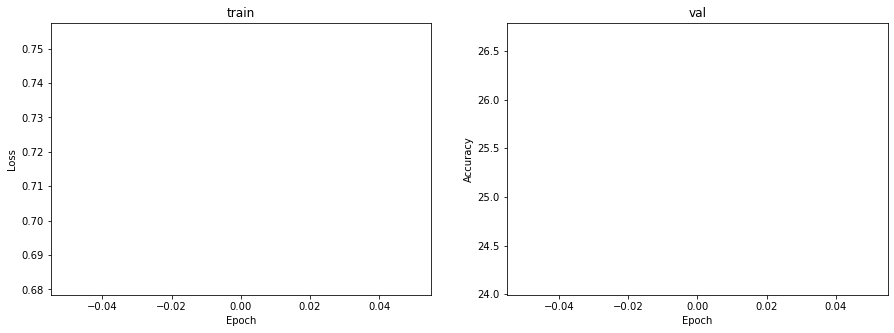

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[15,5], sharex=False, sharey=False)
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")

plotnum = 0
for a in ["train", "val"]:
    # ax1 = fig.add_subplot(120 + plotnum)
    axes[plotnum].set_title(a)
    axes[plotnum].set_xlabel("Epoch")
    for i in range(len(history[a])):
        axes[plotnum].plot(history[a][i])
    plotnum += 1

## Evaluate 

In [7]:
# X, Y, y = X_test, Y_test, y_test
X, Y, y = get_val(X_train, Y_train, y_train) # place holder for real test data

scores, y_pred, y_true, y_labels = evaluate(
    X,  # images
    Y,  # output
    y,  # labels
    model,
    Y.shape[1],
    pred_fn,
    device=torch.device("cpu"),
    dtype=torch.float32,
    transform=None,
)

### Save Evaluation Data

In [11]:
save_raw_eval_data(scores, y_pred, y_true, y_labels, "characteristic")

True

## Train on all the data

In [9]:
dataloader = get_loader(X_train, Y_train, batch_size, transform)
dataloaders = {"train":dataloader}
train_model(
    model,
    optimizer,
    dataloaders,
    loss_fn,
    pred_fn,
    num_epochs,
    show_every=1,
    device=device,
    dtype=torch.float32,
    phases=["train"],
)

Iter: 0
train Loss: 205.0097 Acc: 25.7495


([205.00969511436446], [])